<a href="https://colab.research.google.com/github/Riddars/Hakaton_04.09.23/blob/main/%D0%A7%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%BE%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT**


In [ ]:
!pip install rdkit
!pip install pycaret
!pip install lazypredict
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors

import networkx as nx


import lazypredict
from lazypredict.Supervised import LazyRegressor #Regression

import pickle

import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.3 MB/s eta 0:0

**ЗАГРУЗКА ДАТАСЕТА И УДАЛЕНИЕ ЛИШНЕГО**

In [ ]:
# Загрузка данных из CSV файлов
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton_04.09.23/main/dataset_3090.csv', index_col=0)
# удаляем строчки где в столбце "Animal" значение 0 (их всего 10)
data_df = data_df[data_df['Animal'] != '0']
# удаляем ненужные столбцы
data_df.drop(['Test_indicator', 'Test'], axis=1, inplace=True)

# список значений
values_to_remove = ['C23H40N2O18', 'C56H103N9O39', 'C9H15N3O6']
data_df = data_df[~data_df['Material'].isin(values_to_remove)]

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 0 to 3086
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Material                  2881 non-null   object 
 1   Diameter (nm)             2881 non-null   float64
 2   Zeta potential (mV)       2881 non-null   float64
 3   Cell_type                 2881 non-null   object 
 4   Concentration (g/L)       2881 non-null   float64
 5   Viability (%)             2881 non-null   float64
 6   Coat                      2881 non-null   object 
 7   Line_Primary_Cell         2881 non-null   object 
 8   Animal                    2881 non-null   object 
 9   Cell_morphology           2881 non-null   object 
 10  Cell_age                  2881 non-null   object 
 11  Cell_organ                2881 non-null   object 
 12  Time (h)                  2881 non-null   float64
 13  Molecular weight (g/mol)  2881 non-null   float64
 14  Electron

**АНАЛИЗ ВЫБРОСОВ**

In [ ]:
# имя столбца, для которого считаем процент дисперсии
column_name = 'Concentration (g/L)'

# данные из указанного столбца
data = data_df[column_name]

# Рассчитываем среднее значение
mean_value = np.mean(data)

# Рассчитываем дисперсию
variance = np.var(data, ddof=1)  # ddof=1 используется для выборочной дисперсии

# Рассчитываем процент дисперсии относительно среднего значения
percent_variance = (variance / mean_value) * 100

print("Среднее значение:", mean_value)
print("Дисперсия:", variance)
print("Процент дисперсии относительно среднего значения:", percent_variance, "%")

Среднее значение: 0.04239581063002342
Дисперсия: 0.017314818483945265
Процент дисперсии относительно среднего значения: 40.840871365916136 %


In [ ]:
target_column = 'Concentration (g/L)'
std_deviation = data_df[target_column].std()

# стандартное отклонение
print(f"Стандартное отклонение для столбца '{target_column}': {std_deviation}")

Стандартное отклонение для столбца 'Concentration (g/L)': 0.13158578374560553


**УДАЛЕНИЕ ВЫБРОСОВ**



In [ ]:
# Укажите имена столбцов, для которых вы хотите найти выбросы
columns_to_check = ['Diameter (nm)', 'Zeta potential (mV)', 'Concentration (g/L)', 'Molecular weight (g/mol)']

# Создайте пустой DataFrame для хранения результатов без выбросов
cleaned_df = data_df.copy()

# Проходите по каждому столбцу и удаляйте выбросы
for column_name in columns_to_check:
    Q1 = data_df[column_name].quantile(0.1)
    Q3 = data_df[column_name].quantile(0.9)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data_df[(data_df[column_name] < lower_bound) | (data_df[column_name] > upper_bound)]

    # Удаляем строки с выбросами из cleaned_df
    data_df = cleaned_df.drop(outliers.index)

    num_removed = len(outliers)
    print(f"Количество удаленных строк с выбросами в столбце '{column_name}': {num_removed}")

Количество удаленных строк с выбросами в столбце 'Diameter (nm)': 36
Количество удаленных строк с выбросами в столбце 'Zeta potential (mV)': 0
Количество удаленных строк с выбросами в столбце 'Concentration (g/L)': 114
Количество удаленных строк с выбросами в столбце 'Molecular weight (g/mol)': 0


**СМОТРИМ ДАННЫЕ**

In [ ]:
data_df.head(10)

,Material,Diameter (nm),Zeta potential (mV),Cell_type,Concentration (g/L),Viability (%),Coat,Line_Primary_Cell,Animal,Cell_morphology,Cell_age,Cell_organ,Time (h),Molecular weight (g/mol),Electronegativity,Elements,Ionic radius
0,Ag,28.41,-33.33,HeLa,0.00,3.66,0,L,human,Epithelial,Adult,cervix,72.00,107.87,1.93,Ag,1.09
1,Ag,28.41,-33.33,HeLa,0.00,48.48,0,L,human,Epithelial,Adult,cervix,48.00,107.87,1.93,Ag,1.09
2,Ag,28.41,-33.33,HeLa,0.00,65.96,0,L,human,Epithelial,Adult,cervix,24.00,107.87,1.93,Ag,1.09
3,Ag,28.41,-33.33,HaCat,0.00,23.71,0,L,human,Keratinocyte,Adult,skin,48.00,107.87,1.93,Ag,1.09
4,Ag,28.41,-33.33,HaCat,0.00,20.52,0,L,human,Keratinocyte,Adult,skin,72.00,107.87,1.93,Ag,1.09
5,Ag,28.41,-33.33,HaCat,0.00,21.89,0,L,human,Keratinocyte,Adult,skin,48.00,107.87,1.93,Ag,1.09
6,Ag,28.41,-33.33,HaCat,0.00,3.99,0,L,human,Keratinocyte,Adult,skin,72.00,107.87,1.93,Ag,1.09
7,Ag,28.41,-33.33,HeLa,0.00,18.31,0,L,human,Epithelial,Adult,cervix,24.00,107.87,1.93,Ag,1.09
8,Ag,28.41,-33.33,HeLa,0.00,32.08,0,L,human,Epithelial,Adult,cervix,24.00,107.87,1.93,Ag,1.09
9,Ag,28.41,-33.33,HaCat,0.00,11.56,0,L,human,Keratinocyte,Adult,skin,24.00,107.87,1.93,Ag,1.09


In [ ]:
# смотрим нет ли непонятных значений во всех столбцах кроме числовых
exclude_columns = ['Concentration (g/L)', 'Zeta potential (mV)', 'Diameter (nm)', 'Viability (%)', 'Time (h)', 'Molecular weight (g/mol)', 'Electronegativity', 'Ionic radius']
for column in data_df.columns:
  if column not in exclude_columns:
    unique_values = data_df[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'Material': ['Ag' 'Al2O3' 'Au' 'C23H40N2O18' 'C56H103N9O39' 'C9H15N3O6' 'CdO' 'CeO2'
 'Co3O4' 'Cu2O' 'CuO' 'Fe3O4' 'MgO' 'MnO' 'NiO' 'Pt' 'Se' 'SiO2' 'TiO2'
 'ZnO' 'ZrO2']
Уникальные значения в столбце 'Cell_type': ['HeLa' 'HaCat' 'Caco-2' 'KEC' 'hMSC' 'HCMEC' 'SH-SY5Y' 'CHO-K1' 'HFL1'
 'RAW 264.7' 'HUVEC' 'MDA-MB-231' 'PC12' 'C17.2' 'NHDF' 'MG-63' 'HEK-293'
 'hFOB1.19' '143B' 'MCF-7' 'A549' 'CCL-110' 'RFPEC' 'HepG2' 'H1299' 'L-02'
 'HDF' 'L929' 'K562' 'J774' 'Neuro-2a' 'HT-1080' 'HT29' 'neuro2A' 'SIRC'
 'BEAS-2B' 'Hepatocytes' 'PMA activated THP-1' 'H4' 'hPDLF' 'SKOV-3' 'mDF'
 'hTERT-BJ1' 'Monocytes' 'T98G' '3T3-L1' 'HEp-2' 'THP-1' 'IMR90' 'PC3'
 '16HBE' 'A2780' 'NIH3T3' 'L-132' 'primary alveolar epithelial cells'
 'A431' 'primary tissue Macrophage' 'primary alveolar Macrophage'
 'Fibroblasts' 'IP15' 'LLC-PK1' 'AGS' 'WISH' 'HAEC' 'Lymphocyte' 'Ana-1'
 'CD4+T cells' 'CD3+ T cells' 'NK cells' 'B cells' 'Macrophages'
 'T cells (all types)' 'Naive T-cell' 'Me

In [ ]:
# Проверка типов данных в каждом столбце
data_types = data_df.dtypes
# Вывод результатов
print("\nТипы данных:")
print(data_types)


Типы данных:
Material                     object
Diameter (nm)               float64
Zeta potential (mV)         float64
Cell_type                    object
Concentration (g/L)         float64
Viability (%)               float64
Coat                         object
Line_Primary_Cell            object
Animal                       object
Cell_morphology              object
Cell_age                     object
Cell_organ                   object
Time (h)                    float64
Molecular weight (g/mol)    float64
Electronegativity           float64
Elements                     object
Ionic radius                float64
dtype: object


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 0 to 3086
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Material                  2881 non-null   object 
 1   Diameter (nm)             2881 non-null   float64
 2   Zeta potential (mV)       2881 non-null   float64
 3   Cell_type                 2881 non-null   object 
 4   Concentration (g/L)       2881 non-null   float64
 5   Viability (%)             2881 non-null   float64
 6   Coat                      2881 non-null   object 
 7   Line_Primary_Cell         2881 non-null   object 
 8   Animal                    2881 non-null   object 
 9   Cell_morphology           2881 non-null   object 
 10  Cell_age                  2881 non-null   object 
 11  Cell_organ                2881 non-null   object 
 12  Time (h)                  2881 non-null   float64
 13  Molecular weight (g/mol)  2881 non-null   float64
 14  Electron

(2881, 17)


<Axes: >

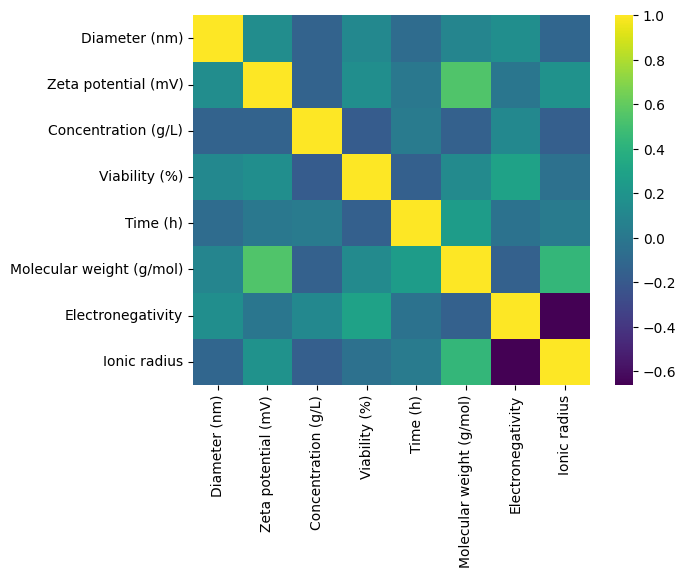

In [ ]:
# посмотрим корреляцию столбцов с числовыми значениями
print(data_df.shape)
sns.heatmap(data_df.corr(), cmap='viridis', yticklabels=True)


**ПОПЫТКА ENCODING**

In [ ]:
le = LabelEncoder()
text_data_features = ['Material', 'Coat', 'Cell_type', 'Line_Primary_Cell', 'Animal', 'Cell_morphology', 'Cell_age', 'Cell_organ', 'Elements']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    data_df[i] = le.fit_transform(data_df[i])
    l3.append(list(data_df[i].unique())); l4.append(list(le.inverse_transform(data_df[i].unique())))
    print(i,' : ',data_df[i].unique(),' = ',le.inverse_transform(data_df[i].unique()))

Label Encoder Transformation


100%|██████████| 9/9 [00:00<00:00, 140.13it/s]

Material  :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]  =  ['Ag' 'Al2O3' 'Au' 'CdO' 'CeO2' 'Co3O4' 'Cu2O' 'CuO' 'Fe3O4' 'MgO' 'MnO'
 'NiO' 'Pt' 'Se' 'SiO2' 'TiO2' 'ZnO' 'ZrO2']
Coat  :  [ 0  8  5  7  6 11 10  3  2  9  4  1]  =  ['0' 'PVP' 'PEG' 'PEI' 'PEG to the PEI'
 'folic acid with intermediate organic (PEG) coating'
 'folic acid with intermediate inorganic (silica) coating' 'Folic acid'
 'Digestive enzymes' 'Phosphonate' 'NH2' 'CTAB']
Cell_type  :  [29 28 15 34 65 20 56 14 24 54 27 41 51 10 46 42 22 64  0 40  5 11 55 30
 17 35 50 25 26 69 57 37  9 31 53 18 66 58 68 67 45 60  2 23 61 32 52  1
  3 47 36 71  4 72 70 16 33 38  6 63 19 39  7 13 12 48  8 43 59 49 44 62
 21]  =  ['HeLa' 'HaCat' 'Caco-2' 'KEC' 'hMSC' 'HCMEC' 'SH-SY5Y' 'CHO-K1' 'HFL1'
 'RAW 264.7' 'HUVEC' 'MDA-MB-231' 'PC12' 'C17.2' 'NHDF' 'MG-63' 'HEK-293'
 'hFOB1.19' '143B' 'MCF-7' 'A549' 'CCL-110' 'RFPEC' 'HepG2' 'H1299' 'L-02'
 'Neuro-2a' 'HT-1080' 'HT29' 'neuro2A' 'SIRC' 'L929' 'BEAS-2B'
 'Hepatocytes' 'P

In [ ]:
# Ваши данные и столбцы для нормализации
columns_to_normalize = ['Concentration (g/L)', 'Zeta potential (mV)', 'Diameter (nm)', 'Time (h)', 'Molecular weight (g/mol)', 'Electronegativity', 'Ionic radius']

# Получите минимальные и максимальные значения для каждого столбца до нормализации
min_values_before = data_df[columns_to_normalize].min()
max_values_before = data_df[columns_to_normalize].max()

print("Минимальные значения до нормализации:")
print(min_values_before)

print("Максимальные значения до нормализации:")
print(max_values_before)

Минимальные значения до нормализации:
Concentration (g/L)          0.00
Zeta potential (mV)        -48.00
Diameter (nm)                1.50
Time (h)                     1.00
Molecular weight (g/mol)    40.30
Electronegativity            1.93
Ionic radius                 0.54
dtype: float64
Максимальные значения до нормализации:
Concentration (g/L)          1.50
Zeta potential (mV)        118.73
Diameter (nm)              957.00
Time (h)                   168.00
Molecular weight (g/mol)   240.80
Electronegativity            2.93
Ionic radius                 1.09
dtype: float64


In [ ]:
columns_to_normalize = ['Concentration (g/L)', 'Zeta potential (mV)', 'Diameter (nm)', 'Time (h)', 'Molecular weight (g/mol)', 'Electronegativity', 'Ionic radius']

# Создайте экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Примените нормализацию к выбранным столбцам
data_df[columns_to_normalize] = scaler.fit_transform(data_df[columns_to_normalize])

# Теперь столбцы 'Feature1', 'Feature2' и 'Feature3' нормализованы в диапазоне [0, 1]
print(data_df)

      Material  Diameter (nm)  Zeta potential (mV)  Cell_type  \
0            0           0.03                 0.09         29   
1            0           0.03                 0.09         29   
2            0           0.03                 0.09         29   
3            0           0.03                 0.09         28   
4            0           0.03                 0.09         28   
...        ...            ...                  ...        ...   
3082        17           0.01                 0.01         21   
3083        17           0.01                 0.01         21   
3084        17           0.01                 0.01         62   
3085        17           0.01                 0.01         21   
3086        17           0.01                 0.01         21   

      Concentration (g/L)  Viability (%)  Coat  Line_Primary_Cell  Animal  \
0                    0.00           3.66     0                  0       2   
1                    0.00          48.48     0                  0

In [ ]:
data_df.to_csv('DF.csv', index=False)

**ПРОБУЕМ РАЗНЫЕ МОДЕЛИ**

In [ ]:

# Загрузка данных
data = data_df

# Подготовка данных
X = data.drop(['Viability (%)'], axis=1).values
y = data['Viability (%)'].values

X_scaled = X

# Разделение данных на обучающий, валидационный и тестовый наборы
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Создание модели нейронной сети
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели с функцией потерь и оптимизатором
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Оценка модели на тестовом наборе данных
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Среднеквадратичная ошибка на тестовом наборе: {test_loss}")
print(f"Средняя абсолютная ошибка на тестовом наборе: {test_mae}")
# Оценка точности модели на тестовой выборке
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Использование модели для предсказания значений
predictions = model.predict(X_test)

# Вывод предсказанных значений и соответствующих истинных значений
for i in range(len(predictions)):
    print(f'Predicted: {predictions[i]}, True: {y_test[i]}')

# Вычисление R2-score
r2 = r2_score(y_test, predictions)
print(f'R2-score: {r2}')

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Epoch 1/200
72/72 [==============================] - 2s 5ms/step - loss: 3180.2983 - mean_absolute_error: 47.6475 - val_loss: 1570.4030 - val_mean_absolute_error: 33.6092
Epoch 2/200
72/72 [==============================] - 0s 2ms/step - loss: 1578.1398 - mean_absolute_error: 32.1670 - val_loss: 1259.3263 - val_mean_absolute_error: 30.0417
Epoch 3/200
72/72 [==============================] - 0s 2ms/step - loss: 1377.3579 - mean_absolute_error: 29.7736 - val_loss: 1142.6733 - val_mean_absolute_error: 28.3298
Epoch 4/200
72/72 [==============================] - 0s 2ms/step - loss: 1306.7993 - mean_absolute_error: 28.7018 - val_loss: 1108.0408 - val_mean_absolute_error: 27.8925
Epoch 5/200
72/72 [==============================] - 0s 3ms/step - loss: 1275.7902 - mean_absolute_error: 28.1794 - val_loss: 1084.4755 - val_mean_absolute_error: 27.3923
Epoch 6/200
72/72 [==============================] - 0s 2ms/step - loss: 1250.6339 - mean_absolute_error: 27.8302 - val_loss: 1066.9136 - val_mea

KeyboardInterrupt: ignored

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 0 to 3086
Columns: 185 entries, Diameter (nm) to Elements_Zr
dtypes: float64(8), uint8(177)
memory usage: 700.6 KB


In [ ]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data_df.drop('Viability (%)', axis=1)
y = data_df['Viability (%)']

# Создание модели случайного леса с настраиваемыми параметрами
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,  # Минимальное количество образцов для разделения
    min_samples_leaf=1,  # Минимальное количество образцов в листовом узле
    random_state=42,
    bootstrap=True,  # Использовать метод бутстрэпа
    oob_score=False,  # Использовать out-of-bag оценку
    criterion='squared_error'  # Функция для измерения качества разделения
)

# Обучение модели случайного леса на всем наборе данных
model.fit(X, y)

# Предсказание на всем наборе данных
y_pred = model.predict(X)

# Оценка производительности модели на всем наборе данных
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 372.36844933813364
R-squared: 0.6786034238710876


[0]	validation_0-rmse:71.97211
[1]	validation_0-rmse:65.66230
[2]	validation_0-rmse:60.15002
[3]	validation_0-rmse:55.17999
[4]	validation_0-rmse:50.72116
[5]	validation_0-rmse:46.74510
[6]	validation_0-rmse:43.25181
[7]	validation_0-rmse:40.24846
[8]	validation_0-rmse:37.53427
[9]	validation_0-rmse:35.16498
[10]	validation_0-rmse:33.20071
[11]	validation_0-rmse:31.47568
[12]	validation_0-rmse:29.98947
[13]	validation_0-rmse:28.69414
[14]	validation_0-rmse:27.67089
[15]	validation_0-rmse:26.72292
[16]	validation_0-rmse:25.98019
[17]	validation_0-rmse:25.32580
[18]	validation_0-rmse:24.79786
[19]	validation_0-rmse:24.29036
[20]	validation_0-rmse:24.11606
[21]	validation_0-rmse:23.93777
[22]	validation_0-rmse:23.62478
[23]	validation_0-rmse:23.36851
[24]	validation_0-rmse:23.45270
[25]	validation_0-rmse:23.27860
[26]	validation_0-rmse:23.16364
[27]	validation_0-rmse:23.08527
[28]	validation_0-rmse:23.00670
[29]	validation_0-rmse:22.83971
[30]	validation_0-rmse:23.00707
[31]	validation_0-

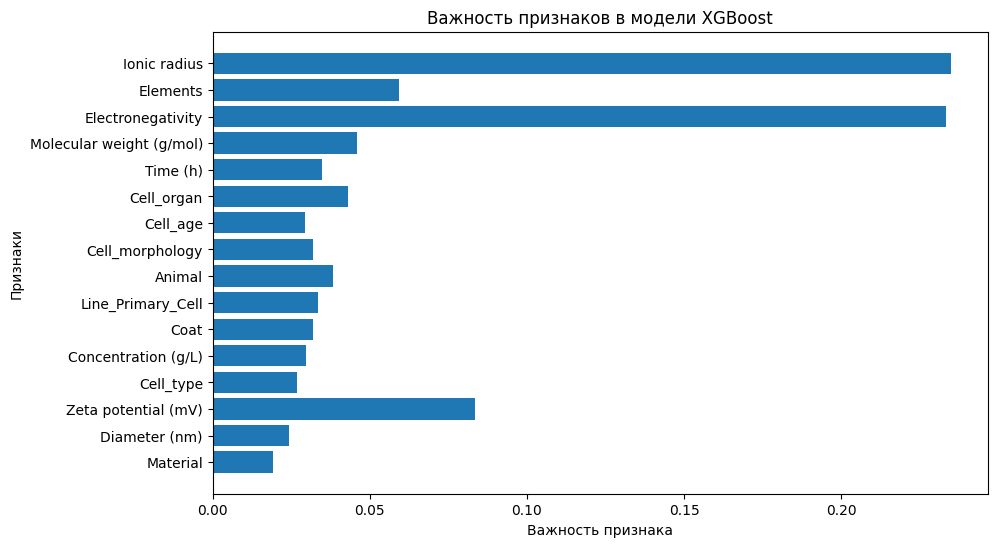

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Разделение данных на признаки (X) и целевую переменную (y)
X = data_df.drop('Viability (%)', axis=1)
y = data_df['Viability (%)']


# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и настройка модели градиентного бустинга (XGBoost)
model = xgb.XGBRegressor(
    n_estimators=100,  # Количество деревьев
    learning_rate=0.1,  # Скорость обучения
    max_depth=10,  # Максимальная глубина деревьев
    min_child_weight=1,  # Минимальный вес в узле
    subsample=0.8,  # Доля обучающих данных для каждого дерева
    colsample_bytree=0.8,  # Доля признаков для каждого дерева
    gamma=0,  # Минимальное уменьшение функции потерь
    reg_alpha=0,  # L1 регуляризация
    reg_lambda=1,  # L2 регуляризация
    objective='reg:squarederror',  # Задача оптимизации для регрессии
)

# Обучение модели
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=1)

# Предсказание на тестовом наборе данных
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# важность признаков
feature_importance = model.feature_importances_

# график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), X_train.columns)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели XGBoost')
plt.show()